# Getting started

### Process settings

**Process settings include price of feeds and products, conditions of utilities, and the chemical engineering plant cost index. These should be set before simulating a system.**

Set the chemical engineering plant cost index:

In [1]:
import biosteam as bst
bst.CE # Default year is 2017

567.5

In [2]:
bst.CE = 603.1 # To year 2018

Set [PowerUtility](https://biosteam.readthedocs.io/en/latest/PowerUtility.html) options:

In [3]:
bst.PowerUtility.price # Default price

0.0782

In [4]:
bst.PowerUtility.price = 0.065 # Adjust price

Set [HeatUtility](https://biosteam.readthedocs.io/en/latest/HeatUtility.html) options:

In [5]:
bst.HeatUtility.cooling_agents # Functions as a dictionary of available cooling agents

CoolingAgents({'Cooling water': <UtilityAgent: T=305.372 K>, 'Chilled water': <UtilityAgent: T=280.372 K>, 'Chilled Brine': <UtilityAgent: T=255.372 K>})

In [6]:
cw = bst.HeatUtility.cooling_agents['Cooling water']
cw # A UtilityAgent


UtilityAgent:
 thermo                Thermo(CompiledChemicals([Water]), ...)
 z_mol                 (1.00,)
 T           K         305.37
 P           Pa        101,325
 phase                 'l'
 Hvap        kJ/kmol   None
 T_limit     K         324.82
 price_kJ    USD/kJ    0
 price_kmol  USD/kmol  0.0004879
 efficiency            1.00


In [7]:
# Data is stored as attributes
(cw.thermo, cw.z_mol, cw.T, cw.P, cw.phase, cw.T_limit, cw.price_kJ, cw.price_kmol, cw.efficiency)

(Thermo(chemicals=CompiledChemicals([Water]), mixture=Mixture('ideal mixing rules', ..., rigorous_energy_balance=True, include_excess_energies=False), Gamma=DortmundActivityCoefficients, Phi=IdealFugacityCoefficients, PCF=IdealPoyintingCorrectionFactors),
 (1,),
 305.372,
 101325,
 'l',
 324.817,
 0,
 0.00048785,
 1)

In [8]:
cw.T = 302 # Change temperature (K)

In [9]:
bst.HeatUtility.heating_agents # Functions as a dictionary of available heating agents

HeatingAgents({'Low pressure steam': <UtilityAgent: T=411.494 K>, 'Medium pressure steam': <UtilityAgent: T=454.484 K>, 'High pressure steam': <UtilityAgent: T=508.858 K>})

In [10]:
bst.HeatUtility.heating_agents['Low pressure steam'] # A UtilityAgent

UtilityAgent:
 thermo                Thermo(CompiledChemicals([Water]), ...)
 z_mol                 (1.00,)
 T           K         411.49
 P           Pa        344,738
 phase                 'g'
 Hvap        kJ/kmol   3.886e+04
 T_limit     K         None
 price_kJ    USD/kJ    0
 price_kmol  USD/kmol  0.2378
 efficiency            0.95


In [11]:
bst.HeatUtility.heating_agents['Low pressure steam'].price_kmol = 0.20 # Change price (USD/kmol)

### Initialize streams

[Stream](https://thermosteam.readthedocs.io/en/latest/Stream.html) objects define material flow rates along with its thermodynamic state. Before creating streams, a thermo property package must be defined through a [Thermo](https://thermosteam.readthedocs.io/en/latest/Thermo.html) object. Please visit [Thermosteam's documentation](https://thermosteam.readthedocs.io/en/latest/index.html) for a complete tutorial on `Stream` objects and BioSTEAM's thermodynamic engine. In this example, a simple feed stream with a few common chemicals will be initialized:

In [12]:
import thermosteam as tmo
chemicals = tmo.Chemicals(['Water', 'Methanol', 'Glycerol'])
tmo.settings.set_thermo(chemicals)
feed = tmo.Stream(Water=20, Glycerol=10)
feed.show()

Stream: s1
 phase: 'l', T: 298.15 K, P: 101325 Pa
 flow (kmol/hr): Water     20
                 Glycerol  10


### Find design requirements and cost with Unit objects

[Creating a Unit](https://biosteam.readthedocs.io/en/latest/Creating a Unit.html) can be flexible. But in summary, a [Unit](https://biosteam.readthedocs.io/en/latest/Unit.html) object is initialized with an ID, and unit specific arguments:

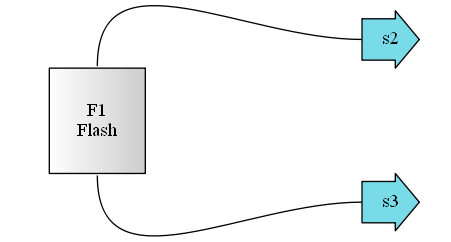

Flash: F1
ins...
[0] missing stream
outs...
[0] s2
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] s3
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


In [13]:
import biosteam as bst
from biosteam import units

# Specify vapor fraction and isobaric conditions
F1 = units.Flash('F1', V=0.5, P=101325)
F1

Note that, by default, Missing Stream objects are given to inputs, `ins`, and empty streams to outputs, `outs`:

In [14]:
F1.ins

[<MissingStream>]

In [15]:
F1.outs

[<Stream: s2>, <Stream: s3>]

You can connect streams by setting the `ins` and `outs`:

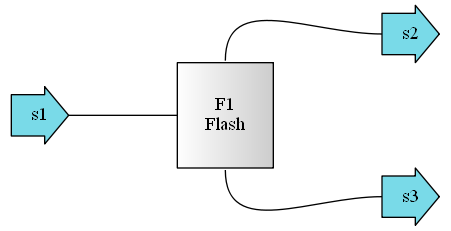

Flash: F1
ins...
[0] s1
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water     20
                    Glycerol  10
outs...
[0] s2
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] s3
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


In [16]:
F1.ins[0] = feed
F1

To simulate the flash, use the `simulate` method:

In [17]:
F1.simulate()
F1.show()

Flash: F1
ins...
[0] s1
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water     20
                    Glycerol  10
outs...
[0] s2
    phase: 'g', T: 382.91 K, P: 101325 Pa
    flow (kmol/hr): Water     15
                    Glycerol  0.00534
[1] s3
    phase: 'l', T: 382.91 K, P: 101325 Pa
    flow (kmol/hr): Water     5.01
                    Glycerol  9.99


The `results` method returns simulation results:

In [18]:
F1.results() # Default returns DataFrame object with units

Flash                                 Units            F1
Low pressure steam  Duty              kJ/hr      1.03e+06
                    Flow            kmol/hr          26.4
                    Cost             USD/hr          5.28
Design              SepType                      Vertical
                    Length               ft          37.5
                    Diameter             ft           6.5
                    Weight               lb      1.28e+04
                    Wall thickness       in         0.375
                    Material                 Carbon steel
Purchase cost       Flash               USD      8.14e+04
                    Heat exchanger      USD      4.89e+03
Total purchase cost                     USD      8.63e+04
Utility cost                         USD/hr          5.28

In [19]:
F1.results(with_units=False) # Returns Series object without units

Low pressure steam   Duty                  1.03e+06
                     Flow                      26.4
                     Cost                      5.28
Design               SepType               Vertical
                     Length                    37.5
                     Diameter                   6.5
                     Weight                1.28e+04
                     Wall thickness           0.375
                     Material          Carbon steel
Purchase cost        Flash                 8.14e+04
                     Heat exchanger        4.89e+03
Total purchase cost                        8.63e+04
Utility cost                                   5.28
Name: F1, dtype: object

### Solve recycle loops and process specifications with System objects

**Designing a chemical process is no easy task. A simple recycle process consisting of a flash with a partial liquid recycle is presented here.**

Create a [Mixer](https://biosteam.readthedocs.io/en/latest/Mixer.html) object and a [Splitter](https://biosteam.readthedocs.io/en/latest/Splitter.html) object:

In [20]:
M1 = units.Mixer('M1')
S1 = units.Splitter('S1', split=0.5) # Split to 0th output stream
F1.outs[0].ID = 'product'

You can [find unit operations and manage flowsheets](https://biosteam.readthedocs.io/en/master/tutorial/Managing%20flowsheets.html) with `find`:

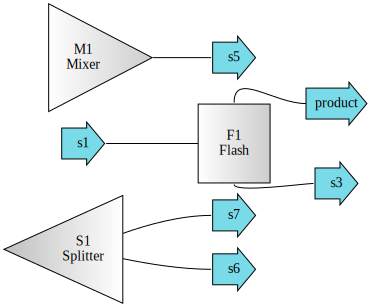

In [21]:
bst.find.diagram()

Connect streams and make a recycle loop using [-pipe- notation](https://biosteam.readthedocs.io/en/latest/Using -pipe- notation.html):

In [22]:
feed = tmo.Stream('feed', Glycerol=100, Water=450)

# Broken down -pipe- notation
[S1-0, feed]-M1     # M1.ins[:] = [S1.outs[0], feed]
M1-F1               # F1.ins[:] = M1.outs
F1-1-S1             # S1.ins[:] = [F1.outs[1]]

# All together
[S1-0, feed]-M1-F1-1-S1;

Create [System](https://biosteam.readthedocs.io/en/latest/System.html) object by specifying an ID, a `recycle` stream and a `network` of units:

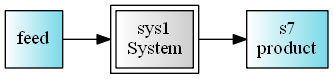

System: sys1
 recycle: s6
 network: (M1, F1, S1)
 convergence error: Flow rate   0.00e+00 kmol/hr
                    Temperature 0.00e+00 K
 iterations: 0


In [23]:
sys1 = bst.System('sys1', network=(M1, F1, S1), recycle=S1-0) # recycle=S1.outs[0]
sys1

View the System object as a Graphviz diagram:

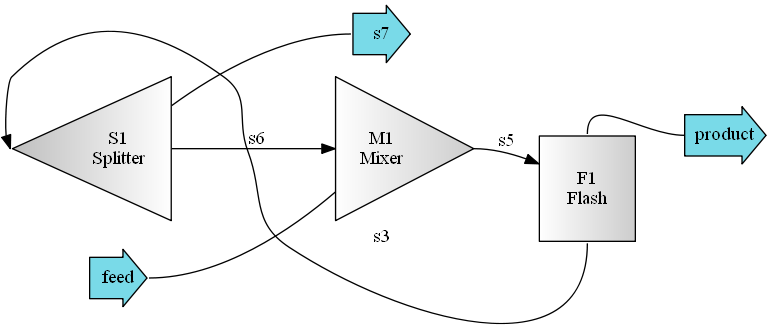

In [24]:
sys1.diagram()

Simulate the System object:

In [25]:
sys1.simulate()
sys1.show()

System: sys1
 recycle: s6
 network: (M1, F1, S1)
 convergence error: Flow rate   5.91e-03 kmol/hr
                    Temperature 8.44e-02 K
 iterations: 5


In [26]:
F1.show()

Flash: F1
ins...
[0] s5  from  Mixer-M1
    phase: 'l', T: 326.07 K, P: 101325 Pa
    flow (kmol/hr): Water     533
                    Glycerol  200
outs...
[0] product
    phase: 'g', T: 377.45 K, P: 101325 Pa
    flow (kmol/hr): Water     367
                    Glycerol  0.0795
[1] s3  to  Splitter-S1
    phase: 'l', T: 377.45 K, P: 101325 Pa
    flow (kmol/hr): Water     167
                    Glycerol  200


In [27]:
F1.results()

Flash                                 Units            F1
Low pressure steam  Duty              kJ/hr      2.15e+07
                    Flow            kmol/hr           553
                    Cost             USD/hr           111
Design              SepType                      Vertical
                    Length               ft          35.5
                    Diameter             ft             6
                    Weight               lb      1.12e+04
                    Wall thickness       in         0.375
                    Material                 Carbon steel
Purchase cost       Flash               USD      7.45e+04
                    Heat exchanger      USD      4.63e+03
Total purchase cost                     USD      7.92e+04
Utility cost                         USD/hr           111

Save a system report:

In [28]:
sys1.save_report('Example.xlsx') # Try this on your computer and open excel

AttributeError: 'Workbook' object has no attribute 'add_worksheet'

Once process settings are set and the system is simulated, it is possible to perform [techno-economic analysis](https://biosteam.readthedocs.io/en/latest/Techno-economic analysis.html). If a [TEA](https://biosteam.readthedocs.io/en/latest/TEA.html) object of the system was initialized, TEA results would also appear in the report.

### Join the community!

BioSTEAM will become more relevant with communitity involvement. It is strongly encouraged to share designs and new [Unit subclasses](https://biosteam.readthedocs.io/en/latest/Inheriting from Unit.html), no matter how preliminary or rigorous they are.